# Projet 7 : Réaliser une analyse de sentiments grâce au Deep Learning

## Contexte
* **Entreprise:** Air Paradis, compagnie aérienne.
* **Problématique:**
    * Préparer un prototype fonctionnel du modèle. Le modèle est exposé via une API déployée sur le Cloud, appelée par une interface locale (notebook ou application Streamlit) qui envoie un tweet à l’API et récupère la prédiction de sentiment.
    * Préparer un support de présentation explicitant les méthodologies utilisées pour les différentes approches (attention : audience non technique)

* **Objectif:** Développer un produit IA permettant d’anticiper les bad buzz sur les réseaux sociaux.

## Données
* **TWEETS:**

## Approches Envisagées
* **Traitement du Langage Naturel:**
    * Vectorisation des descriptions textuelles.
    * (Naive Bayes, SVM, etc.).

## Bénéfices Attendus
* **Gain de temps:** Automatisation d'une tâche répétitive.
* **Amélioration de la qualité des données:** Catégorisation plus précise et cohérente des sentiments.
* **Passage à l'échelle:** Facilité pour gérer un volume de tweets.

#I. Importation

###A. Importation des bibliothèques

In [25]:
# Bibliothèques standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Traitement texte
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, \
                            roc_curve, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

#Connecter au drive.
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###B. Importation du fichier

In [26]:
df = pd.read_csv('/content/drive/My Drive/Projet_7/training.1600000.processed.noemoticon.csv',
                 encoding='latin-1', header=None)
data = df.copy()

# Renomer les colonnes
data.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

# Renommer les catégories de sentiments (0 = negative, 4 = positive)
data['target'] = data['target'].replace(4, 1)

#II. Exploration

##A. Analyse du fichier



In [ ]:
data.head(5)

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


<Axes: >

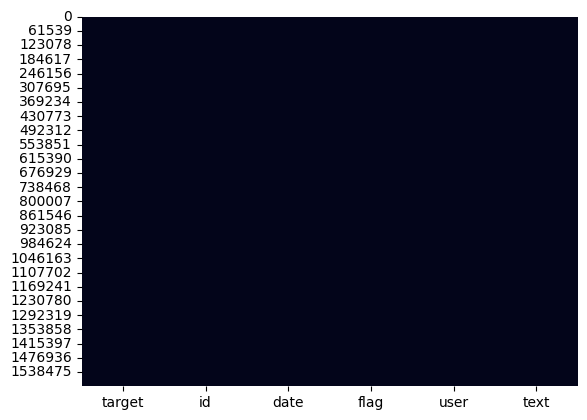

In [ ]:
# Afficher une heatmap des valeurs manquantes.
sns.heatmap(data.isna(), cbar=False)

In [27]:
# Identification des lignes avec des doublons dans la colonne "id"
duplicates = data[data.duplicated(subset=['id'])]
print(len(duplicates))

1685


In [28]:
# Suppression des doublons pour id en conservant la première occurrence
data_without_duplicated = data.drop_duplicates(subset='id', keep='first')

In [29]:
# Identification des lignes avec des doublons dans la colonne "id"
second_duplicates = data_without_duplicated[data_without_duplicated.duplicated(subset=['date', 'user', 'text'])]
print(len(second_duplicates))

188


In [30]:
# Suppression des doublons pour date, user, texte en conservant la première occurrence
data = data_without_duplicated.drop_duplicates(subset=['date', 'user', 'text'], keep='first')

In [31]:
print(data.shape)

(1598127, 6)


Le DataFrame contient 1598127 tweets, décrits par 6 caractéristiques. La cible qui est le sentiment négatif égal à 0 et le sentiment positif égal à 1. Les caractéristiques explicatives sont l'identifiant du tweets, le flag, la date, le rédacteur et le texte.

L'analyse préliminaire révèle une qualité de données satisfaisante, avec peu de valeurs manquantes.

##B. Analyse des variables

###1. Cible

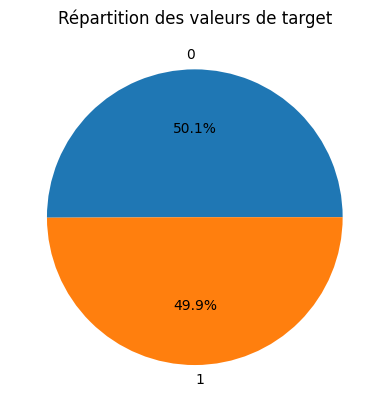

In [ ]:
import matplotlib.pyplot as plt

# Compter les occurrences (corrigé)
value_counts = data['target'].value_counts()

# Créer un diagramme circulaire avec Matplotlib
plt.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
plt.title('Répartition des valeurs de target')
plt.show()

###2. Utilisateur

In [ ]:
# Compter les occurrences de chaque valeur dans la colonne 'target'
value_counts = data['user'].value_counts(normalize=True, sort=True)
print(value_counts)

user
lost_dog           3.435271e-04
webwoke            2.158777e-04
tweetpet           1.933513e-04
SallytheShizzle    1.758308e-04
VioletsCRUK        1.745794e-04
                       ...     
alannamalyn        6.257325e-07
robertreset        6.257325e-07
juicybabyyy        6.257325e-07
david_ashley       6.257325e-07
bpbabe             6.257325e-07
Name: proportion, Length: 659775, dtype: float64


###3. Date

In [ ]:
# Compter les occurrences de chaque valeur dans la colonne 'target'
value_counts = data['date'].value_counts(normalize=True, sort=True)
print(value_counts)

date
Mon Jun 15 12:53:14 PDT 2009    1.251465e-05
Mon Jun 15 13:39:50 PDT 2009    1.063745e-05
Fri May 22 05:10:17 PDT 2009    1.063745e-05
Fri May 29 13:40:04 PDT 2009    1.063745e-05
Fri Jun 05 14:13:07 PDT 2009    1.001172e-05
                                    ...     
Sun Jun 07 12:31:22 PDT 2009    6.257325e-07
Sun Jun 07 12:31:19 PDT 2009    6.257325e-07
Sun Jun 07 12:31:17 PDT 2009    6.257325e-07
Sun Jun 07 12:31:16 PDT 2009    6.257325e-07
Tue Jun 16 08:40:50 PDT 2009    6.257325e-07
Name: proportion, Length: 774363, dtype: float64


###4. Flag

In [ ]:
# Compter les occurrences de chaque valeur dans la colonne 'target'
value_counts = data['flag'].value_counts(normalize=True, sort=True)
print(value_counts)

flag
NO_QUERY    1.0
Name: proportion, dtype: float64


##C. Pré-traitement du texte

Les tweets contiennent souvent des mentions d'autres utilisateurs, des liens hypertextes, des émojis et de la ponctuation. Pour entraîner un modèle de langage sur ces données, il est nécessaire de les nettoyer et de les prétraiter.

Étapes de prétraitement :

* Minusculisation : Conversion de tout le texte en minuscules pour une meilleure uniformité.

* Remplacement des URL : Remplacement des liens par un mot générique comme "URL" pour éviter qu'ils soient traités comme des mots.

* Remplacement des émojis : Association des émojis à des représentations textuelles (par exemple, ":)" devient "SOURIRE") à l'aide d'un dictionnaire prédéfini.

* Remplacement des noms d'utilisateur : Remplacement des noms d'utilisateur par un mot générique comme "UTILISATEUR" pour protéger la vie privée.

* Suppression des caractères non alphabétiques : Suppression des caractères qui ne sont ni des chiffres ni des lettres pour se concentrer sur le contenu textuel.

* Réduction des lettres consécutives : Réduction des lettres consécutives à un maximum de deux pour gérer les répétitions de caractères.

* Suppression des mots courts : Suppression des mots de moins de deux caractères, car ils ont souvent peu de sens.

* Suppression des stop-words : Elimination des mots courants (stop-words) qui contribuent peu au sens global du texte.

* Lemmatisation : Réduction des mots à leur racine (lemme) pour diminuer le nombre de mots uniques et améliorer la généralisation.

**Stemming et Lemmatisation**

En raison des règles grammaticales, les documents utilisent différentes formes d'un même mot, comme "écrire", "écrivant" et "écrit". De plus, il existe des familles de mots dérivés ayant des significations similaires. Le but du stemming et de la lemmatisation est de réduire les formes flexionnelles et parfois les formes dérivées d'un mot à une forme de base commune.

* **Stemming** est généralement un processus qui consiste à couper les fins des mots dans l'espoir d'atteindre le but correctement la plupart du temps. Il inclut souvent la suppression des affixes dérivationnels.

* **Lemmatisation** est généralement un processus plus précis qui utilise un vocabulaire et une analyse morphologique des mots pour supprimer uniquement les terminaisons flexionnelles et retourner la forme de base et la forme du dictionnaire d'un mot.

In [32]:
# Definir le dictionnaire contenant les émojis avec leurs significations.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# Definir tous les stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']
final_stopwords = list(stopwords.words('english'))+stopwordlist

# Créer un Lemmatiseur et un Stemming.
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer(language='english')

# Définir des modèles d'expressions régulières.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern       = '@[^\s]+'
alphaPattern      = "[^a-zA-Z0-9]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

In [33]:
def preprocess_text(tweet: str,
                    stem_or_lem: str = "lem"
                    ) -> str:
    """
    Cette fonction applique le prétraitement à un tweet :
      1* Si le tweet est une liste, concaténe en une seule chaine.
      2* Convertir le tweet en minuscule.
      3* Remplacez toutes les URL par «URL».
      4* Remplacer tous les emojis par un mot.
      5* Remplacer @USERNAME par 'USER'.
      6* Remplacer tous les caractères non alphabets par un espace.
      7* Remplacer 3 lettres consécutives ou plus par 2 lettres.
      8* Vérifier si le mot est dans stopwordlist.
      9* Lemmatiser ou stemmed le mot si pas dans stopword.
    Args:
      tweet (str): Texte du tweet à prétraiter.
      stem_or_lem (str): Valeurs possibles "lem"/"stem". Permet de choisir si
      le texte doit être stemmé ou lemmatisé.
    Returns:
      tweetwords (str): Texte après le prétraitement
    """

    if type(tweet) == list:
        tweet = " ".join(tweet)
    # Convertir le tweet en minuscule.
    tweet = tweet.lower()
    # Remplacez toutes les URL par «URL».
    tweet = re.sub(urlPattern,"URL",tweet)
    # Remplacer tous les emojis par un mot.
    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
    # Remplacer @USERNAME par 'USER'.
    tweet = re.sub(userPattern,' USER', tweet)
    # Remplacer tous les caractères non alphabets par un espace.
    tweet = re.sub(alphaPattern, " ", tweet)
    # Remplacer 3 lettres consécutives ou plus par 2 lettres.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    tweetwords = ''
    for word in tweet.split():
        # Vérifier si le mot est dans stopwordlist:
        if len(word)>1 and word not in final_stopwords:
            # Lemmatizing ou stemming le mot si pas dans stopword.
            if stem_or_lem == "lem":
                word = lemmatizer.lemmatize(word)
            elif stem_or_lem == "stem":
                word = stemmer.stem(word)
            tweetwords += (word+' ')

    return tweetwords

In [ ]:
data["preprocessed_stem"] = data["text"].apply(lambda x: preprocess_text(x, stem_or_lem="stem"))

In [ ]:
data["preprocessed_lem"] = data["text"].apply(lambda x: preprocess_text(x, stem_or_lem="lem"))

In [ ]:
data.head()

,target,id,date,flag,user,text,preprocessed_stem,preprocessed_lem
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",user url aww bummer shoulda got david carr thi...,USER URL aww bummer shoulda got david carr thi...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...,upset update facebook texting might cry result...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,user dive mani time ball manag save 50 rest go...,USER dived many time ball managed save 50 rest...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire,whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",user behav mad see,USER behaving mad see


#III. Division du dataset

In [34]:
# Diviser le dataset
X_train, X_test, y_train, y_test = train_test_split(data["text"],
                                                    data["target"],
                                                    test_size = 0.15)

#IV. Modèle sur mesure simple


##First. MLflow Tracking avec DagsHubs

###Install MLFlow & the DagsHub python client

In [35]:
%pip install -q dagshub mlflow

###Use the DagsHub client to setup connection information for MLflow

In [36]:
import dagshub
dagshub.init(repo_owner='maximemasson65', repo_name='my-first-repo', mlflow=True)

Initialized MLflow to track repo "maximemasson65/my-first-repo"

Repository maximemasson65/my-first-repo initialized!

##A. Vectorisation TF-IDF

In [37]:
# Appliquer le pré-traitement avec lemmatisation
X_train_preprocessed = [preprocess_text(text) for text in X_train]
X_test_preprocessed = [preprocess_text(text) for text in X_test]

In [38]:
# TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=0.005, max_df=0.99)
# Entainer le modèle
tfidf_vectorizer.fit(X_train_preprocessed)
# Obtenir les noms caractéristiques.
tfidf_features = tfidf_vectorizer.get_feature_names_out()
print("[INFO] : Nombre de caractéristiques dans le vocabulaire : ", len(tfidf_features))

[INFO] : Nombre de caractéristiques dans le vocabulaire :  235


In [ ]:
print(tfidf_vectorizer.get_feature_names_out())

['actually' 'already' 'also' 'always' 'amazing' 'amp' 'another' 'anything'
 'around' 'away' 'awesome' 'aww' 'baby' 'back' 'bad' 'beautiful' 'bed'
 'best' 'better' 'big' 'birthday' 'bit' 'bored' 'boy' 'call' 'cant' 'car'
 'check' 'cold' 'come' 'coming' 'cool' 'could' 'damn' 'day' 'done' 'dont'
 'early' 'emojiwink' 'end' 'even' 'ever' 'everyone' 'exam' 'excited'
 'feel' 'feeling' 'finally' 'find' 'first' 'follow' 'follower' 'found'
 'friday' 'friend' 'fun' 'game' 'get' 'getting' 'girl' 'give' 'glad' 'go'
 'god' 'going' 'gone' 'gonna' 'good' 'got' 'gotta' 'great' 'guess' 'guy'
 'haha' 'happy' 'hard' 'hate' 'head' 'hear' 'help' 'hey' 'hi' 'home'
 'hope' 'hot' 'hour' 'house' 'hurt' 'im' 'job' 'keep' 'know' 'last' 'late'
 'later' 'least' 'left' 'let' 'life' 'like' 'little' 'live' 'lol' 'long'
 'look' 'looking' 'lost' 'lot' 'love' 'lt' 'luck' 'made' 'make' 'making'
 'man' 'many' 'may' 'maybe' 'mean' 'might' 'miss' 'missed' 'missing' 'mom'
 'monday' 'morning' 'movie' 'much' 'music' 'must' 'nee

In [39]:
# Transformer les données.
X_train_lr = tfidf_vectorizer.transform(X_train_preprocessed)
X_test_lr  = tfidf_vectorizer.transform(X_test_preprocessed)

In [40]:
from joblib import dump, load
# Enregistrement
dump(tfidf_vectorizer, '/content/drive/My Drive/Projet_7/tfidf_vectorizer.joblib')

['/content/drive/My Drive/Projet_7/tfidf_vectorizer.joblib']

##B. Régression Logistique

In [41]:
def evaluate_model(model, use_cv=False):
    """
    Cette fonction évalue un modèle
    Args:
      model (sklearn model): modèle à évaluer.
      use_cv (boolean): contrôle la crossvalidation.
    Returns:
      Rien
    """
    # Effectue le test avec ou sans cross-validation
    if use_cv:
        y_pred = cross_val_predict(model, X_test_lr, y_test)
    else:
        y_pred = model.predict(X_test_lr)

    # Effectue le test en donnant la probabilité
    if use_cv:
        pred_prob = cross_val_predict(model, X_test_lr, y_test, method='predict_proba')
    else:
        pred_prob = model.predict_proba(X_test_lr)

    # Mise en place du score AUC
    auc_score = roc_auc_score(y_test, pred_prob[:,1])
    print("ROC AUC score : ", round(auc_score, 3))

    # Mise en place de la courbe roc
    fpr, tpr, _ = roc_curve(y_test,  pred_prob[:,1])

    # Afficher la courbe roc
    fig_roc_curve, ax_roc_curve = plt.subplots()
    ax_roc_curve.plot(fpr,tpr,label="AUC="+str(round(auc_score, 3)))
    ax_roc_curve.set_ylabel("True Positive Rate")
    ax_roc_curve.set_xlabel("False Positive Rate")
    ax_roc_curve.legend(loc=4)

    # Afficher le rapport de classification.
    print(classification_report(y_test, y_pred))

    # Afficher la matrice de confusion
    cf_matrix = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=["Negative", "Positive"])
    fig_cmd, ax_cmd = plt.subplots()
    cmd.plot(ax=ax_cmd)

    return auc_score, fig_roc_curve, fig_cmd

In [42]:
import mlflow

ROC AUC score :  0.775
              precision    recall  f1-score   support

           0       0.70      0.69      0.70    119940
           1       0.70      0.71      0.70    119780

    accuracy                           0.70    239720
   macro avg       0.70      0.70      0.70    239720
weighted avg       0.70      0.70      0.70    239720



2025/01/24 13:51:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Modèle de régression logistique at: https://dagshub.com/maximemasson65/my-first-repo.mlflow/#/experiments/0/runs/a39fdc3324924bc88d77164acfaa9966
🧪 View experiment at: https://dagshub.com/maximemasson65/my-first-repo.mlflow/#/experiments/0


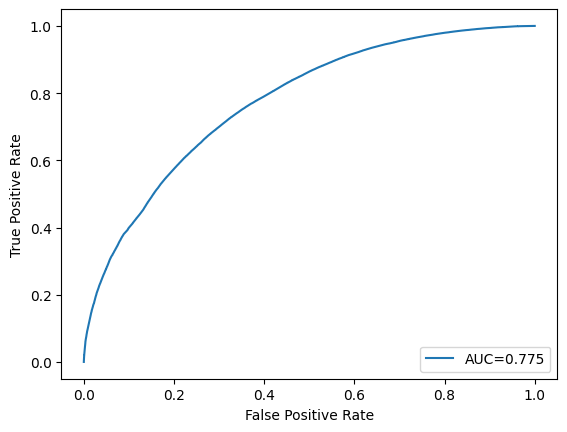

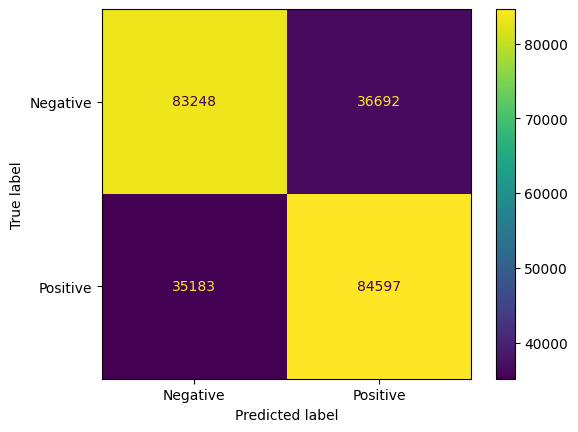

In [ ]:
with mlflow.start_run(run_name="Modèle de régression logistique"):
    # Params
    max_iter = 1000
    # Save params
    mlflow.log_param("max_iter", max_iter)
    # Model
    model_log_reg = LogisticRegression(max_iter=max_iter)
    model_log_reg.fit(X_train_lr, y_train)

    auc_score, fig_roc_curve, fig_cmd = evaluate_model(model_log_reg, use_cv=True)
    # Save Metrics
    mlflow.log_metric("auc", auc_score)
    # Save figure
    mlflow.log_figure(fig_roc_curve, "fig_roc_curve.png")
    mlflow.log_figure(fig_cmd, "fig_cmd.png")
    # Enregistrer le modèle
    mlflow.sklearn.log_model(model_log_reg, "model_log_reg")

Tunnel http : ngrok donne une adresse publique

##C. XGBoost

In [43]:
import xgboost as xgb

ROC AUC score :  0.745
              precision    recall  f1-score   support

           0       0.67      0.68      0.67    119929
           1       0.67      0.66      0.67    119791

    accuracy                           0.67    239720
   macro avg       0.67      0.67      0.67    239720
weighted avg       0.67      0.67      0.67    239720



2025/01/24 15:13:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Modèle de Xgboost at: https://dagshub.com/maximemasson65/my-first-repo.mlflow/#/experiments/0/runs/4e03909d96e44688a053db8db6340232
🧪 View experiment at: https://dagshub.com/maximemasson65/my-first-repo.mlflow/#/experiments/0


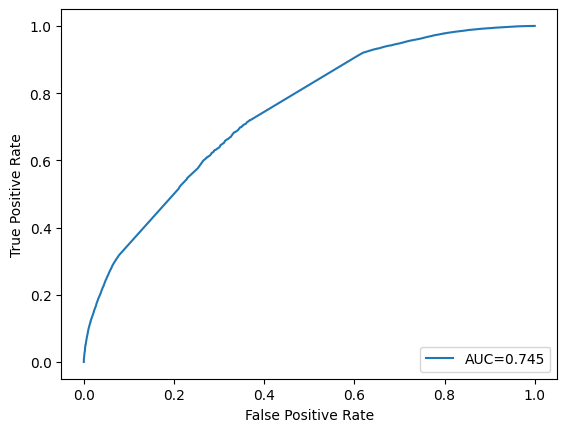

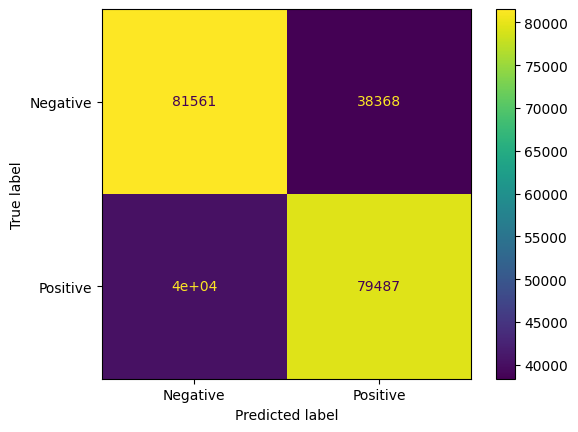

In [45]:
with mlflow.start_run(run_name="Modèle de Xgboost"):
    # Params
    objective = 'binary:logistic'
    eval_metric='auc'
    n_estimators=100
    max_depth=3
    learning_rate=0.1
    random_state=42

    # Save params
    mlflow.log_param("objective", objective)
    mlflow.log_param("eval_metric", eval_metric)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("random_state", random_state)
    # Mise en place du modèle de XGBoost
    model_xgb = xgb.XGBClassifier(
        objective=objective,
        eval_metric=eval_metric,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        use_label_encoder=False
        )
    model_xgb.fit(X_train_lr, y_train)

    auc_score, fig_roc_curve, fig_cmd = evaluate_model(model_xgb, use_cv=False)
    # Save Metrics
    mlflow.log_metric("auc", auc_score)
    # Save figure
    mlflow.log_figure(fig_roc_curve, "fig_roc_curve.png")
    mlflow.log_figure(fig_cmd, "fig_cmd.png")
    # Enregistrer le modèle
    mlflow.sklearn.log_model(model_xgb, "model_xgb")

ROC AUC score :  0.782
              precision    recall  f1-score   support

           0       0.71      0.69      0.70    119929
           1       0.70      0.71      0.71    119791

    accuracy                           0.70    239720
   macro avg       0.70      0.70      0.70    239720
weighted avg       0.70      0.70      0.70    239720



2025/01/24 15:24:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Modèle de Xgboost at: https://dagshub.com/maximemasson65/my-first-repo.mlflow/#/experiments/0/runs/b806a8014ca04b4f95bed48eaf039b72
🧪 View experiment at: https://dagshub.com/maximemasson65/my-first-repo.mlflow/#/experiments/0


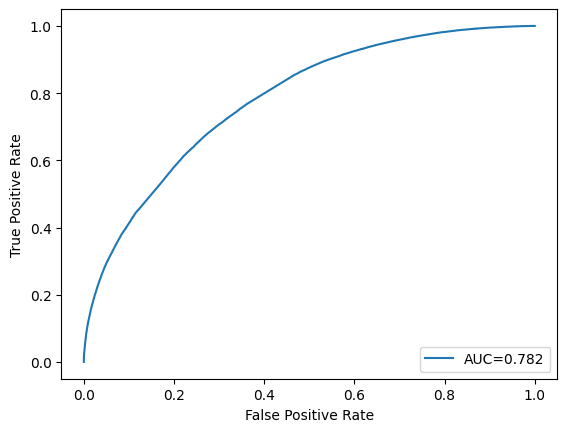

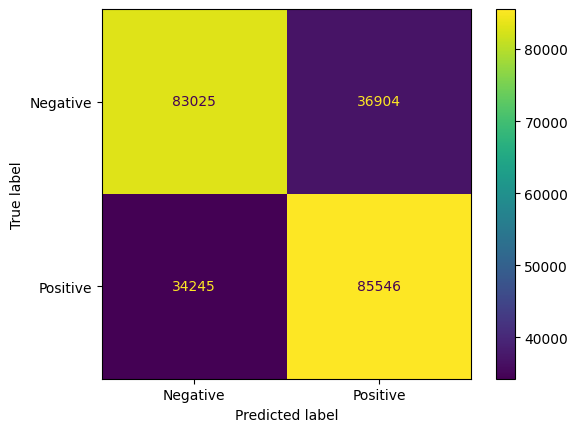

In [46]:
with mlflow.start_run(run_name="Modèle de Xgboost"):
    # Params
    objective = 'binary:logistic'
    eval_metric='auc'
    n_estimators=500
    max_depth=3
    learning_rate=0.1
    random_state=42

    # Save params
    mlflow.log_param("objective", objective)
    mlflow.log_param("eval_metric", eval_metric)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("random_state", random_state)
    # Mise en place du modèle de XGBoost
    model_xgb = xgb.XGBClassifier(
        objective=objective,
        eval_metric=eval_metric,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        use_label_encoder=False
        )
    model_xgb.fit(X_train_lr, y_train)

    auc_score, fig_roc_curve, fig_cmd = evaluate_model(model_xgb, use_cv=False)
    # Save Metrics
    mlflow.log_metric("auc", auc_score)
    # Save figure
    mlflow.log_figure(fig_roc_curve, "fig_roc_curve.png")
    mlflow.log_figure(fig_cmd, "fig_cmd.png")
    # Enregistrer le modèle
    mlflow.sklearn.log_model(model_xgb, "model_xgb")

In [ ]:
model_xgb.save_model('/content/drive/My Drive/Projet_7/xgb_model.model')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:27:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


#V. Modèle sur mesure avancé: LSTM

##A. Pré-traitement

Avant d'insérer des données textuelles dans un réseau neuronal, nous devons repenser le processus de prétraitement

###1. Importer les modules

In [ ]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

###2. Tokenization

In [ ]:
# Vectoriser le texte.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Obtenir le nombre de mots
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Nombre de mots:", vocab_size)

Nombre de mots: 619925


###3. Pad

L'objet tokenizer peut être utilisé pour convertir n'importe quel mot en une clé dans le dictionnaire.

Pour construire un modèle de séquence, je dois introduire une séquence de nombres. Et également s'assurer qu'il n'y a pas de variation dans les formes d'entrée des séquences. Tout doit être de la même longueur. Mais les textes dans les tweets ont un nombre de mots différent. Pour éviter cela, le pad fera toute la séquence dans une longueur constante MAX_SEQUENCE_LENGTH.

La longueur des tweets est la plupart du temps égale à 140. La longueur maximal de la séquence est définit à 140.

In [ ]:
MAX_SEQUENCE_LENGTH = 140

In [ ]:
# Pad
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = MAX_SEQUENCE_LENGTH)
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train_padded.shape)
print("Testing X Shape:",X_test_padded.shape)

Training X Shape: (1358407, 140)
Testing X Shape: (239720, 140)


###4. Label encoding

Le modèle pour prédire la classe sous forme codée (0 ou 1 car il s'agit d'une classification binaire). Nous devons encoder nos étiquettes d'entraînement en encodages

In [ ]:
# label encoder
encoder = LabelEncoder()
encoder.fit(y_train)

y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Reshape
y_train_encoded = y_train_encoded.reshape(-1,1)
y_test_encoded = y_test_encoded.reshape(-1,1)

print("y_train shape:", y_train_encoded.shape)
print("y_test shape:", y_test_encoded.shape)

y_train shape: (1358407, 1)
y_test shape: (239720, 1)


In [ ]:
def preprocess_sequence(X_train, X_test):
    """
    Cette fonction permet le pre traitement

    Args:
      X_train (np.array): Textes d'entrainement à pré-traités
      X_test (np.array): Textes de test à pré-traités
      y_train (np.array): Sentiment d'entrainement à pré-traités
      y_test (np.array): Sentiment de test à pré-traités

    Returns:
      X_train_padded (np.array): Textes d'entrainement pré-traités
      X_test_padded  (np.array): Textes de test pré-traités
      y_train_encoded (np.array): Sentiment d'entrainement encoder
      y_test_encoded (np.array): Sentiment encoder
      vocab_size (int): Longueur du vocabulaire
      tokenizer (Keras Tokenizer): Entraîner sur X_train
    """

    # Tokenizer le texte.
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)

    word_index = tokenizer.word_index
    vocab_size = len(tokenizer.word_index) + 1
    print("Vocabulary Size :", vocab_size)

    # Pad
    X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
    X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test),
                           maxlen = MAX_SEQUENCE_LENGTH)

    # label encoder
    encoder = LabelEncoder()
    encoder.fit(y_train)
    y_train_encoded = encoder.transform(y_train)
    y_test_encoded = encoder.transform(y_test)

    # Reshape
    y_train_encoded = y_train_encoded.reshape(-1,1)
    y_test_encoded = y_test_encoded.reshape(-1,1)

    return X_train_padded, X_test_padded, y_train_encoded, y_test_encoded, vocab_size, tokenizer

In [ ]:
X_train_padded, X_test_padded, y_train_encoded, y_test_encoded, vocab_size, tokenizer = preprocess_sequence(X_train, X_test)

Vocabulary Size : 619925


##B. Modèle

Dans le modèle de langage, les mots sont représentés de manière à donner plus de sens et à apprendre les modèles et le sens contextuel qui se cachent derrière.

L'incorporation de mots est l'une des représentations les plus populaires du vocabulaire des documents. Elle est capable de capturer le contexte d'un mot dans un document, la similarité sémantique et syntaxique, la relation avec d'autres mots, etc.

Il s'agit essentiellement d'une représentation vectorielle de caractéristiques de mots qui sont utilisés pour d'autres applications de traitement du langage naturel.

J'utilise ici l'apprentissage par transfert. Je télécharge l'incorporation pré-entraînée et l'utilisons du modèle.

L'incorporation de mots pré-entraînée comme GloVe, Word2Vec ou Fasttext donne plus d'informations sur un mot qui peut être utilisé pour la classification

###1. Téléchargement de Glove embedding

In [ ]:
# Télécharger les fichiers Glove embedding.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-12-10 08:21:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-12-10 08:21:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-10 08:21:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

###2. Téléchargement de Fasttext embedding

In [ ]:
# Télécharger les fichier Fasttext embedding.
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gunzip cc.en.300.vec.gz

--2024-12-10 08:25:00--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.144.74, 18.154.144.87, 18.154.144.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.154.144.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  51.3MB/s    in 28s     

2024-12-10 08:25:28 (45.5 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



###3. Créer une matrice d'embedding

Pour entraîner nos modèles d'apprentissage profond, nous avons besoin d'une couche d'intégration qui aura certains poids. Ces poids seront le coefficient dans une matrice d'intégration

In [ ]:
# Pour les modèles Glove et Fasttext, des vecteurs de longueur 300 on été choisit
EMBEDDING_DIM = 300
EMBEDDING_DICT = {"glove":"glove.6B.300d.txt", "fasttext":"cc.en.300.vec"}

In [ ]:
def get_embedding_matrix(embedding_file, vocab_size):

    """
    Cette fonction met en place la fonction d'embedding
    Args:
      embedding_file (str): chemin vers le fichier du modèle d'intégration
      vocab_size (int): Longueur du vocabulaire
    Returns:
      embedding_matrix (np.array): matrice d'intégration qui sera utilisée
      pour la couche d'intégration
    """
    # Création d'un dictionnaire d'index d'intégration utilisé pour
    # mapper les mots avec leur vecteur
    embeddings_index = {}

    print("[INFO] : Calcul de la matrice d'intégration pour : ", embedding_file)

    # Transformer le fichier d'intégration en dictionnaire
    with open(embedding_file) as f:
        for line in f:
          values = line.split()
          word = value = values[0]
          coefs = np.asarray(values[1:], dtype='float32')
          embeddings_index[word] = coefs

        print('Found %s word vectors.' %len(embeddings_index))

    # Créer la matrice d'intégration de taille [vocab_size, EMBEDDING_DIM]
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
embedding_matrix = get_embedding_matrix(embedding_file="glove.6B.300d.txt", vocab_size=vocab_size)

[INFO] : Calcul de la matrice d'intégration pour :  glove.6B.300d.txt
Found 400000 word vectors.


###4. Créer le modèle Deep learning

####a. Créer une couche d'embedding

La couche d'intégration sera la première couche des réseaux de neurones. Il convertira les séquences de texte en vecteurs d'intégration

In [ ]:
# Créer de la couche d'intégration
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#### b. Créer le modèle

LSTM - Long Short Term Memory, c'est une variante de RNN qui a une cellule d'état de mémoire pour apprendre le contexte des mots qui se trouvent plus loin dans le texte afin de porter une signification contextuelle plutôt que de simples mots voisins comme dans le cas de RNN.

In [ ]:
from keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Flatten, SpatialDropout1D
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau

In [ ]:
def get_bidirLSTM_model(dropout_rate, optimizer, loss_function):

    """
    Cette fonction crée et compile un modèle LSTM bidirectionnel.

    Args:
      dropout_rate (float): Une partie des neurones à désactiver sur chaque couche
      optimizer (Keras optimizer): Optimiseur à utiliser pour la descente de gradient
      loss_function (str): Fonction de perte à utiliser pour calculer l'erreur empirique

    Returns:
      model (Keras model): modèle compilé créé selon une architecture spécifique

    """

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Bidirectional(LSTM(24))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(sequence_input, outputs)

    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

    return model

####c. Entraînement

In [ ]:
def plot_train_results(training_history):
    '''
    Fonction pour afficher les courbes d'apprentissage du modèle sur les données d'entraînement
    Args:
      training_history (History object): Historique d'entrainement.
    Returns:
      Rien
    '''
    fig_accuracy_curve, ax_accuracy_curve = plt.subplots()
    ax_accuracy_curve.plot(training_history.history['accuracy'])
    ax_accuracy_curve.plot(training_history.history['val_accuracy'])
    ax_accuracy_curve.set_title('model accuracy')
    ax_accuracy_curve.set_ylabel('accuracy')
    ax_accuracy_curve.set_xlabel('epoch')
    ax_accuracy_curve.legend(['train', 'test'], loc='upper left')

    fig_loss_curve, ax_loss_curve = plt.subplots()
    ax_loss_curve.plot(training_history.history['loss'])
    ax_loss_curve.plot(training_history.history['val_loss'])
    ax_loss_curve.set_title('model loss')
    ax_loss_curve.set_ylabel('loss')
    ax_loss_curve.set_xlabel('epoch')
    ax_loss_curve.legend(['train', 'test'], loc='upper left')

    return fig_accuracy_curve, fig_loss_curve

In [ ]:
def decode_sentiment_label(score):
    """
    Cette fonction:
      * Compare un score d'entrée avec un seuil.
      * Fournit une classe d'étiquette.
    Args:
      score (float): score d'entrée.
    Returns:
      label (str): Valeurs "Positive"/"Negative" correspondant au score.
    """
    return "Positive" if score>0.5 else "Negative"

def decode_sentiment_class(score):
    """
    Cette fonction :
      * Compare un score d'entrée avec un seuil.
      * Fournit un identifiant de classe.
    Args:
      score (float): score d'entrée
    Returns:
      ID (int): Valeurs binaires correspondant à la class
    """
    return 1 if score>0.5 else 0

In [ ]:
def evaluate_keras_model(model, xtest, ytest):
    """
    Cette fonction évalue un modèle entraîné.
    Args:
      model (Keras model): un modèle Keras entraîné.
    Returns:
      auc_score (float): AUC score du modèle sur l'ensemble de test.
      f1 (float): F1 score du modèle sur l'ensemble de test.
      acc (float): accuracy score du modèle sur l'ensemble de test.

    """
    # Prédire les probabilités.
    pred_prob = model.predict(xtest)
    # Prédire les valeurs pour l'ensemble de données de test.
    y_pred = [decode_sentiment_class(score) for score in pred_prob]

    # auc score
    auc_score = roc_auc_score(ytest, pred_prob)
    print("ROC AUC score : ", round(auc_score, 3))
    # f1_score
    f1 = round(f1_score(ytest, y_pred), 3)
    print("F1 Score : ", f1)
    # f1_score
    acc = round(accuracy_score(ytest, y_pred), 3)
    print("Accuracy Score : ", acc)

    # Créer ROC curve
    fpr, tpr, _ = roc_curve(ytest,  pred_prob)

    # Afficher la courbe roc
    fig_roc_curve, ax_roc_curve = plt.subplots()
    ax_roc_curve.plot(fpr,tpr,label="AUC="+str(round(auc_score, 3)))
    ax_roc_curve.set_ylabel("True Positive Rate")
    ax_roc_curve.set_xlabel("False Positive Rate")
    ax_roc_curve.legend(loc=4)

    # Afficher le rapport de classification.
    print(classification_report(y_test, y_pred))

    # Afficher la matrice de confusion
    cf_matrix = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=["Negative", "Positive"])
    fig_cmd, ax_cmd = plt.subplots()
    cmd.plot(ax=ax_cmd)

    return auc_score, f1, acc, fig_roc_curve, fig_cmd

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 140)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 140, 300)            │     185,977,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 140, 300)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 48)                  │          62,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,040,701 (709.69 MB)

 Trainable params: 63,201 (246.88 KB)

 Non-trainable params: 185,977,500 (709.45 MB)

Epoch 1/20
10613/10613 ━━━━━━━━━━━━━━━━━━━━ 223s 20ms/step - accuracy: 0.7456 - loss: 0.5162 - val_accuracy: 0.7966 - val_loss: 0.4383 - learning_rate: 0.0010
Epoch 2/20
10613/10613 ━━━━━━━━━━━━━━━━━━━━ 218s 21ms/step - accuracy: 0.7871 - loss: 0.4577 - val_accuracy: 0.8021 - val_loss: 0.4263 - learning_rate: 0.0010
Epoch 3/20
10613/10613 ━━━━━━━━━━━━━━━━━━━━ 267s 21ms/step - accuracy: 0.7928 - loss: 0.4485 - val_accuracy: 0.8055 - val_loss: 0.4228 - learning_rate: 0.0010
Epoch 4/20
10613/10613 ━━━━━━━━━━━━━━━━━━━━ 281s 23ms/step - accuracy: 0.7952 - loss: 0.4443 - val_accuracy: 0.8033 - val_loss: 0.4233 - learning_rate: 0.0010
Epoch 5/20
10613/10613 ━━━━━━━━━━━━━━━━━━━━ 260s 23ms/step - accuracy: 0.7982 - loss: 0.4406 - val_accuracy: 0.8077 - val_loss: 0.4177 - learning_rate: 0.0010
Epoch 6/20
10613/10613 ━━━━━━━━━━━━━━━━━━━━ 256s 22ms/step - accuracy: 0.7985 - loss: 0.4395 - val_accuracy: 0.8087 - val_loss: 0.4158 - learning_rate: 0.0010
Epoch 7/20
10613/10613 ━━━━━━━━━━━━━━━━━━━━ 25

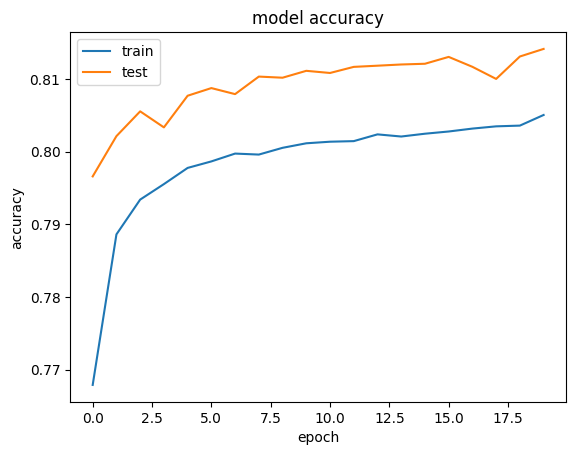

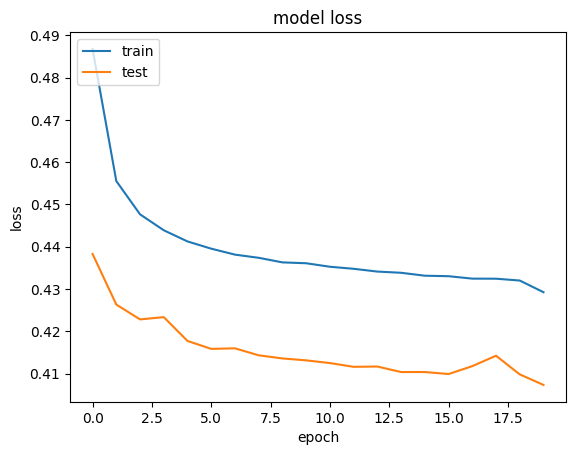

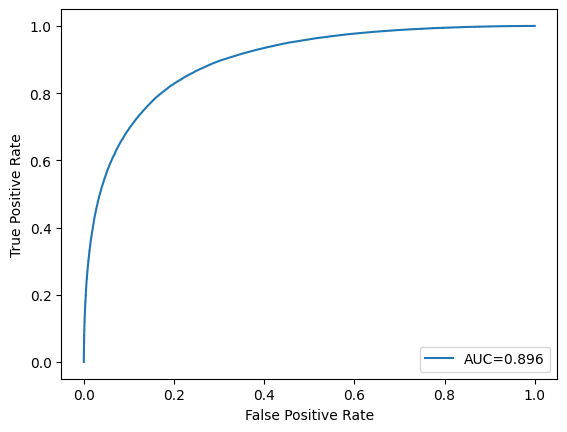

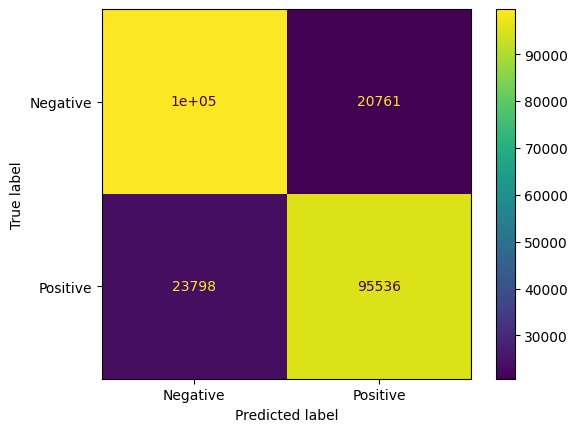

In [ ]:
with mlflow.start_run(run_name="Modèle de bidirLSTM"):
    # Params
    dropout_rate=0.25
    optimizer='adam'
    loss_function='binary_crossentropy'

    BATCH_SIZE=128
    EPOCHS= 20

    # Save params
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("loss_function", loss_function)

    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("epochs", EPOCHS)

    # Mise en place du modèle de XGBoost
    with tf.device('/gpu:0'):
      # Appeler get_bidirLSTM_model pour obtenir un LSTM bi-directionel.
      model = get_bidirLSTM_model(dropout_rate=dropout_rate,
                                  optimizer=optimizer,
                                  loss_function=loss_function)
      # Check the model architecture
      model.summary()
      # Instancier un rappel de réducteur LR
      ReduceLRCallback = ReduceLROnPlateau(factor=0.5,
                                           min_lr = 1e-10,
                                           monitor = 'val_loss',
                                           patience = 3,
                                           verbose = 1)
      history = model.fit(X_train_padded, y_train_encoded,
                          batch_size=BATCH_SIZE, epochs=EPOCHS,
                          validation_data=(X_test_padded, y_test_encoded),
                          callbacks=[ReduceLRCallback])
      # Enregistrer les métriques
      fig_accuracy_curve, fig_loss_curve = plot_train_results(history)

      auc_score, f1, acc, fig_roc_curve, fig_cmd = evaluate_keras_model(model,
                                                                        xtest=X_test_padded,
                                                                        ytest=y_test_encoded)
      # Save Metrics
      mlflow.log_metric("auc", auc_score)
      mlflow.log_metric("f1", f1)
      mlflow.log_metric("acc", acc)

      # Save figure
      mlflow.log_figure(fig_accuracy_curve, "fig_accuracy_curve.png")
      mlflow.log_figure(fig_loss_curve, "fig_loss_curve.png")
      mlflow.log_figure(fig_roc_curve, "fig_roc_curve.png")
      mlflow.log_figure(fig_cmd, "fig_cmd.png")

In [ ]:
model.save("/content/drive/My Drive/Projet_7/bidirLSTM_model.keras")

In [ ]:
import pickle
with open('/content/drive/My Drive/Projet_7/tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

# VI. Comparaison Modèles avancés: BERT

Le modèle BERT signifiant Bidirectionnel Encoders Representations from Transformers fait l'objet d'un second notebook.